## `ContinousControl Project` Report
by: Pradeep Pujari (ppujari@gmail.com)

Completion date: 18 Aug 2018

---
### The Environment

Unity provides a variety of machine learning environments as part of their [`ml-agents`][mlagents] project. Particularly, the chosen project is referred to as `Reacher` &ndash; this is a Continous Control task, which is notably difficult for machine learning agents, especially reinforcement learners. This most challenging aspect of this task is that it has a continuous action space – which makes the actions highly dimensional, and discretizing it can further complicate things.

The goal is to implement an algorithm that's been successful in Continuous Control environments and also benefits from "shared learning" between agents, rather than learning on an individual scale (as this can take extremely lengthy time periods).



[mlagents]: https://github.com/Unity-Technologies/ml-agents

---
### The Algorithm

I chose to use the DDPG algorithm (Deep Deterministic Policy Gradients), as described in [_Continuous Control with Deep Reinforcement Learning_][ddpg-paper] (Lillicrap et al). The foundation of this code-base is from the [Udacity DRL `ddpg-bipedal` notebook][ddpg-repo].

[ddpg-paper]: https://arxiv.org/pdf/1509.02971.pdf
[ddpg-repo]: https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-bipedal/DDPG.ipynb

Completed both single agent and multi agent version

In [1]:
from unityagents import UnityEnvironment
#single agent
#env = UnityEnvironment(file_name='../reacher_1_agent/Reacher', worker_id=0, seed=2)
## 20 agents
env = UnityEnvironment(file_name='../Reacher', worker_id=0, seed=2)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


The observation space, per agent, consists of 33 variables – these all correspond to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints – every action vector value is between `\[-1, 1\]`.

However, I modified the `ddpg-bipedal` code by adding connective code to interact with `Reacher`, scaling up to 20-agents, implementing checkpointing for each `Actor` and `Critic`, adding environmental completion logic, and plotting average score (of 20-agents) over 400 episodes.

---
### Implementation

#### Episodic breakdown
```python    
## ... initial setup
env_solv = False
env_info = env.reset(train_mode=False)[brain_name]

states = env_info.vector_observations

agents = [Agent(**agent_kwargs) for _ in range(n_agents)]
action = [agent.act(states[idx]) for idx, agent in enumerate(agents)]
for epis in range(1, n_epis + 1):

    states = env_info.vector_observations

    ## reset the agent
    for agent in agents:
        agent.reset()

    ## ... time-step loop

    ## ... progress output and checkpointing
```
1. This resets the Unity environment and obtains about the current state, current reward, and the completion state of current episode for each of the 20 arms in the `Reacher` environment.
1. Records the current state information (as provided in `env_info`).
1. Initializes the score for the current episode to zero.
1. And, finally, executes a set of time steps making up a single episode.

#### Time-step breakdown
This can run up to 500 time-steps &ndash; an arbitrary "time" limit.
```python
## ... time-step loop
for t in range(max_t):
    actions = [agent.act(states[idx]) for idx, agent in enumerate(agents)]

    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done

    step_tuple = zip(agents, states, actions, rewards, next_states, dones)
    for agent, s, a, r, s_, d in step_tuple:
        agent.step(s, a, r, s_, d)

    states  = next_states
    scores += rewards

    if np.any(dones):
        break
```
1. For each agent, obtain the next action (based on current state and the current value of $\epsilon$.
1. Move to the next time-step, taking the actions just obtained.
1. Gather `next_states`, `rewards`, and `done` values.
1. Take a learning step based on the previous tuples received (`states`, `actions`, `rewards`, `next_states`, and `dones`).
1. Update the current state to `next_states` and compound overall score with the received rewards.
1. Move to the next episode if the environment's task is completed.

Using a `deque`, keep track of the past 100 episodes and keep a general list of scores to be able to generate progression plots as well.

---
### Agent

| Hyperparamter  | Replay buffer | Mini-batch | $\gamma$ | $\tau$ | `Actor lr` | `Critic lr` | `weight_decay` |
|----------------|---------------|------------|----------|--------|------------|-------------|----------------|
| **Size/Value** |           1MM |         64 |     0.99 | 0.0001 |     0.0001 |      0.0003 |         0.0001 |

#### Methods (of each Agent)
```python
class Agent():
    def __init__: 
        # initializes both Actor and Critic local and target networks
        
    def step:     
        # always saves experience to the ReplayBuffer, and on everytime the ReplayBuffer exceeds the batch_size

    def act:      
        # returns a real-valued (in [-1, 1]) action based on the current state and epsilon factor
        # output is the calculated action based on the inputted state space (current time_step) through the MLP
        # actions tend to have noise added, based on Ornstein-Uhlenbeck process
        # lastly, the value is clipped [-1, 1] (as the noise could push the actions outside of said range)
        
    def learn:
        # updates the policy and value params based on the incoming experiences
        # Q_targs = r + \gamma * critic_targ(s', actor_targ(s')), 
        #     where s' = next_state, actor_targ(s) yields action, critic_targ(s, a) yields Q-value
        
    def soft_update:
        # performs a soft-update, which how the local and target models exchange parameters; the value of \tau affects
        #     how much information is shared, where the target network takes on ...
        #     `tau * local_params + (1 - tau) * target_params`
```
There's also an additional `ReplayBuffer`, which stores past experiences so that learning can take place not only on immediately passing results but also those from far earlier timesteps.

---
### Results

DDPG ran for 300 episodes, producing a final average score of `88.75`. env __solved__ @ i_episode=157, w/ avg_score=30.35 Below is a graph of the results for single agent.

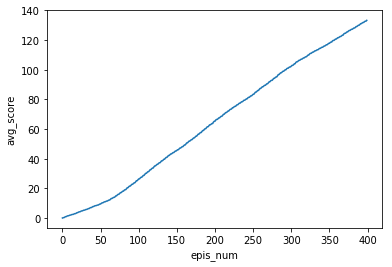

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel("avg_score")
plt.xlabel("epis_num")
plt.show()

---
### Future Work

To improve scores as well as variability in this task the `Actor` and `Critic` Networks could have both been further complexified (e.g. adding more layers or more units per layer). This setup also didn't really seem to be slowing down, so increasing number of episode likely to result in higher scores.

Other possibilities include the improvements made to DDPG, such as D3PG and D4PG, A3C and PPO reading through those papers leads me to believe they would have produced better results, I am trying to implement PPO based on the openAI blog now.